总体思路
1 选定股票池
2 获取因子数据以及股价
3 IC分析，选出适合的因子
4 关联性分析，关联性高的因子只取其一
5 打分法选股
需要手调的部分：股票池，选股时期，因子方向测试

调参测试结果
调参频率,IC阈值，相关性阈值，年化，夏普
    5    0.01     0.5     0.29   18
    1    0.01     0.7     0.43   28
    1    0        1       0.37   25
    1    0.015    0.75    0.56   37

In [19]:
test_frequency=30
IC_threshold=0.02
corr_threshold=0.75
numOfStockHolding=15

In [3]:
import pandas as pd
import numpy as np
import jqdata
from jqfactor import get_factor_values

# 第一部分，获取数据以及基本的数据处理

In [4]:
startDate="2018-12-01"
endDate="2020-12-01"

dates_read=jqdata.get_trade_days(startDate,endDate)
dates=[]
for i in range(len(dates_read)):
    if i%test_frequency==0:
        dates.append(dates_read[i])
dates[:10]

[datetime.date(2018, 12, 3),
 datetime.date(2019, 1, 16),
 datetime.date(2019, 3, 6),
 datetime.date(2019, 4, 18),
 datetime.date(2019, 6, 4),
 datetime.date(2019, 7, 17),
 datetime.date(2019, 8, 28),
 datetime.date(2019, 10, 17),
 datetime.date(2019, 11, 28),
 datetime.date(2020, 1, 10)]

In [10]:
#获取某指数
stocks=list(get_all_securities(types=["stock"],date=startDate).index)

In [11]:
#获取因子
df=pd.DataFrame()
for date in dates:
    factors=["size","beta","momentum","residual_volatility",
                "non_linear_size","book_to_price_ratio","liquidity","earnings_yield","growth","leverage"]
    fund=get_factor_values(securities=stocks, factors=factors,start_date=date, end_date=date)  
    df_factor=pd.DataFrame()
    for factor in factors:
        fund_factor=fund[factor].T
        fund_factor.columns=[factor]
        df_factor=pd.concat([df_factor,fund_factor],axis=1)
    df_factor["date"]=date    
    df=pd.concat([df,df_factor],axis=0)
df.head()

,size,beta,momentum,residual_volatility,non_linear_size,book_to_price_ratio,liquidity,earnings_yield,growth,leverage,date
code,,,,,,,,,,,
000001.XSHE,0.999240,0.222590,0.716350,-0.037518,-1.178392,1.809353,0.680365,1.401043,0.000597,1.666105,2018-12-03
000002.XSHE,0.999240,0.902345,0.379728,0.357091,-1.178392,-0.568860,0.593633,1.399707,1.041021,1.450618,2018-12-03
000004.XSHE,-3.194177,-2.119116,-1.025309,-0.291836,-1.450484,-1.953903,-0.940967,-1.029893,2.118496,-1.169010,2018-12-03
000005.XSHE,-2.299677,0.825250,-1.017753,-0.829186,1.564426,-0.862302,-0.380849,-1.024907,2.335112,-0.832385,2018-12-03
000006.XSHE,-1.418077,1.060514,-0.940001,-0.040941,2.150049,0.416076,0.166359,0.126231,-0.082945,-0.411175,2018-12-03


In [12]:
#获取财务数据
from jqdata import finance
df_financial=pd.DataFrame()
for date in dates:
    q=query(valuation.code,valuation.pe_ratio,valuation.market_cap,
            valuation.pb_ratio,balance.good_will,income.total_operating_revenue,
            income.net_profit,income.basic_eps,indicator.roe,
            indicator.net_profit_margin
           ).filter(valuation.code.in_(stocks))
    fund=get_fundamentals(q,str(date))
    fund["date"]=date
    df_financial=pd.concat([df_financial,fund])
df_financial.index=df_financial["code"]
del df_financial["code"]
df_financial.head()

,pe_ratio,market_cap,pb_ratio,good_will,total_operating_revenue,net_profit,basic_eps,roe,net_profit_margin,date
code,,,,,,,,,,
300028.XSHE,-2.1909,2.6486,1.2640,NaN,4.809997e+05,-2836372.00,-0.0082,-1.34,-589.68,2018-12-03
002323.XSHE,11.2104,9.7691,1.1732,142379600.0,6.030585e+07,-2985198.25,-0.0038,-0.34,-4.95,2018-12-03
002260.XSHE,-1.8952,10.1572,-4.5404,NaN,2.541734e+08,-3792006.50,-0.0100,1.65,-1.49,2018-12-03
002473.XSHE,-29.1976,10.7520,3.7437,NaN,3.939258e+07,-5469272.50,-0.0333,-1.84,-13.88,2018-12-03
300029.XSHE,21.2964,10.7800,4.7931,NaN,1.046987e+06,-9763902.00,-0.0436,-3.80,-932.57,2018-12-03


In [13]:
#合并财务数据和因子数据
data=pd.DataFrame()
data=pd.merge(df,df_financial,on=["code","date"],how="inner")
data=data.dropna()
data=data.set_index(["date",data.index])
data.head()

size        ...          net_profit_margin
date       code                         ...                           
2018-12-03 000001.XSHE  0.999240        ...                      24.08
           000002.XSHE  0.999240        ...                      11.81
           000004.XSHE -3.194177        ...                      -8.56
           000005.XSHE -2.299677        ...                      -0.29
           000007.XSHE -2.556329        ...                      24.24

[5 rows x 19 columns]

In [14]:
#去极值中性化
def mad(factor):
    me=np.median(factor)
    mad=np.median(abs(factor-me))
    up=me+1.4826*mad*3
    down=me-1.4826*mad*3
    factor=np.where(factor>up,up,factor)
    factor=np.where(factor<down,down,factor)
    return factor
def stand(factor):
    mean=factor.mean()
    std=factor.std()
    return (factor-mean)/std
for name in data.columns:
    if name == "market_cap": #不处理market cap 和日期
        continue
    data[name]=mad(data[name])
    data[name]=stand(data[name])
data.head()

size        ...          net_profit_margin
date       code                         ...                           
2018-12-03 000001.XSHE  2.521915        ...                   1.411769
           000002.XSHE  2.521915        ...                   0.375807
           000004.XSHE -1.635036        ...                  -1.344040
           000005.XSHE -0.748315        ...                  -0.645801
           000007.XSHE -1.002735        ...                   1.425277

[5 rows x 19 columns]

In [15]:
#中性化
from sklearn.linear_model import LinearRegression
data=data.fillna(0)
for name in data.columns:
    if name == "market_cap":
        continue
    y_factor=data[name]
    lr=LinearRegression()
    lr.fit(data['market_cap'].values.reshape(-1,1),y_factor)
    y_predict=lr.predict(data['market_cap'].values.reshape(-1,1))
    data[name]=y_factor-y_predict
data.head()

size        ...          net_profit_margin
date       code                         ...                           
2018-12-03 000001.XSHE  1.640370        ...                   1.097909
           000002.XSHE  1.081948        ...                  -0.136870
           000004.XSHE -1.530731        ...                  -1.306904
           000005.XSHE -0.654152        ...                  -0.612275
           000007.XSHE -0.904747        ...                   1.460164

[5 rows x 19 columns]

In [16]:
#获取收盘价
price_stocks=pd.DataFrame()
for i in range(len(dates)):
    price_now=get_price(stocks,str(dates[i]),str(dates[i]),fields=['close'],fq="pre").iloc[:,0,:].T                          
    price_now["date"]=[dates[i]]
    price_stocks=pd.concat([price_stocks,price_now])
#这里一定要注意，要将price_stocks.index的格式从object转为Datatimes，否则下面alphalens不能用
price_stocks["date"]=price_stocks["date"].apply(pd.to_datetime,format='%Y-%m-%d')
price_stocks.index=price_stocks["date"]
del price_stocks["date"]
price_stocks.head()

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:113: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  fill_paused=fill_paused)


,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,000012.XSHE,000014.XSHE,000016.XSHE,000017.XSHE,000018.XSHE,000019.XSHE,000020.XSHE,000021.XSHE,000022.XSHE,000023.XSHE,000025.XSHE,000026.XSHE,000027.XSHE,000028.XSHE,000029.XSHE,000030.XSHE,000031.XSHE,000032.XSHE,000034.XSHE,000035.XSHE,000036.XSHE,000037.XSHE,000038.XSHE,000039.XSHE,000040.XSHE,000042.XSHE,000043.XSHE,000045.XSHE,000046.XSHE,000048.XSHE,...,603916.XSHG,603917.XSHG,603918.XSHG,603919.XSHG,603920.XSHG,603922.XSHG,603926.XSHG,603928.XSHG,603929.XSHG,603933.XSHG,603936.XSHG,603937.XSHG,603938.XSHG,603939.XSHG,603955.XSHG,603958.XSHG,603959.XSHG,603960.XSHG,603963.XSHG,603966.XSHG,603968.XSHG,603969.XSHG,603970.XSHG,603976.XSHG,603977.XSHG,603978.XSHG,603979.XSHG,603980.XSHG,603985.XSHG,603986.XSHG,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-03,10.59,25.73,16.72,3.08,5.54,7.39,3.97,4.91,4.16,10.17,4.35,9.63,3.79,5.12,2.57,7.59,11.03,6.29,17.48,12.77,27.92,7.79,5.39,46.09,11.17,3.98,5.24,7.51,15.43,4.55,5.89,5.05,14.09,11.44,9.07,12.05,7.95,6.02,5.16,20.40,...,11.76,13.15,13.19,13.95,12.22,18.03,14.85,15.95,16.25,20.58,15.99,11.93,17.90,50.40,15.79,8.63,15.44,30.49,13.20,9.05,14.13,4.64,15.57,15.29,7.48,22.33,7.96,12.74,20.50,79.46,6.98,10.88,21.30,33.05,19.00,4.09,8.43,8.30,5.30,5.09
2019-01-16,10.48,25.42,16.71,2.96,5.39,7.12,4.01,4.46,3.53,9.93,4.18,9.87,3.46,4.82,2.76,7.34,10.84,6.18,NaN,12.24,27.43,8.00,5.32,40.68,11.17,4.04,5.05,8.39,12.75,5.22,5.70,5.10,12.59,11.38,7.26,11.59,7.95,6.42,5.03,17.50,...,11.75,12.00,12.60,12.14,12.10,17.44,15.19,13.89,15.28,18.35,14.92,11.94,17.80,43.08,14.53,8.24,16.17,26.02,12.12,9.37,13.56,5.02,15.30,17.77,7.23,20.03,7.70,12.15,20.39,60.80,6.48,10.27,19.52,31.90,19.33,3.82,8.10,7.79,5.06,4.98
2019-03-06,13.08,29.48,19.02,3.74,6.35,7.53,4.75,6.22,4.12,11.07,5.44,11.49,5.08,5.23,3.01,8.22,12.58,7.96,NaN,17.36,34.79,8.83,6.42,48.27,11.17,4.89,6.18,9.38,15.00,5.61,6.66,9.93,14.71,13.74,8.48,13.55,8.74,7.44,7.04,20.02,...,13.27,13.20,14.60,13.36,13.65,18.40,16.49,15.20,18.13,20.95,18.70,13.47,20.98,54.17,17.79,9.00,21.86,31.78,16.53,10.77,15.21,5.41,17.27,18.70,8.60,24.13,8.90,14.38,27.68,106.95,7.34,12.07,21.64,47.86,20.74,5.07,12.26,8.77,6.39,6.30
2019-04-18,14.34,30.70,21.30,3.94,6.71,7.16,4.72,6.64,3.68,11.74,5.48,11.87,5.48,5.36,2.93,8.26,12.70,8.98,NaN,16.03,34.75,8.95,6.36,48.75,11.17,5.80,7.11,10.10,15.63,5.24,7.87,12.91,14.74,15.30,9.10,12.25,10.04,7.92,7.73,22.99,...,15.45,13.73,15.09,15.98,14.16,20.85,18.08,15.68,20.40,21.30,20.35,13.20,23.41,56.74,18.38,9.88,23.71,36.30,17.78,12.98,18.22,5.78,17.88,18.45,8.58,21.28,9.65,18.29,25.00,99.57,7.58,12.37,20.80,55.68,23.80,4.82,11.08,11.04,13.56,7.02
2019-06-04,11.85,26.30,21.29,2.86,5.45,6.83,3.74,5.59,3.45,9.41,4.52,9.54,4.20,4.27,1.34,7.03,10.75,8.66,NaN,13.12,19.95,7.67,5.89,41.63,11.17,4.82,6.13,9.00,12.60,4.42,7.25,9.63,7.43,12.30,6.70,9.85,10.79,6.93,6.27,19.61,...,12.22,11.26,13.63,14.06,13.75,15.70,15.53,12.98,17.98,17.76,17.53,10.84,18.04,60.79,14.69,7.72,12.78,25.00,13.28,10.31,15.79,4.53,18.60,15.48,10.27,21.89,8.09,13.64,15.17,75.48,6.75,10.68,19.17,29.62,18.67,3.90,4.87,7.24,8.71,5.20


In [11]:
type(price_stocks.index)

pandas.core.indexes.datetimes.DatetimeIndex

# 第二部分，IC分析以及因子间相关性分析选因子

In [17]:
#计算IC值
from alphalens import performance,plotting,tears,utils
import scipy.stats as st

factor_name_list=data.columns
IC_list=[]
for name in factor_name_list:
    single_factor=data.ix[:,name]
    #注意这个max_loss要调大些，并且数据量要多
    factor_return=utils.get_clean_factor_and_forward_returns(single_factor,price_stocks,max_loss=0.99)
    IC=performance.factor_information_coefficient(factor_return).iloc[:,0].mean()
    IC_list.append(IC)

IC_list=pd.DataFrame(IC_list,index=factor_name_list,columns=["IC value"])
IC_list


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 58.9% entries from factor data (58.9% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exce

,IC value
size,0.003445
beta,0.002561
momentum,0.031336
residual_volatility,-0.106348
non_linear_size,-0.041624
book_to_price_ratio,0.006202
liquidity,-0.079821
earnings_yield,0.014137
growth,-0.007573
leverage,-0.035476


In [20]:
#选出IC值>IC_threshold的作为因子
factor_list=IC_list[abs(IC_list["IC value"])>IC_threshold].index
factor_list

Index(['momentum', 'residual_volatility', 'non_linear_size', 'liquidity',
       'leverage', 'good_will', 'net_profit', 'basic_eps', 'roe',
       'net_profit_margin'],
      dtype='object')

In [14]:
data_new=data[factor_list]
data_new.head()

residual_volatility        ...          net_profit_margin
date       code                                    ...                           
2020-02-03 600000.XSHG            -0.650206        ...                   1.573923
           600008.XSHG            -1.075717        ...                   0.127196
           600011.XSHG            -0.302186        ...                  -0.292117
           600017.XSHG            -1.205428        ...                   0.751264
           600018.XSHG            -0.232784        ...                   1.868408

[5 rows x 4 columns]

#查看因子方向,第五组大说明因子值越大越好
factor_name="size"
factor_direction=utils.get_clean_factor_and_forward_returns(
    data.ix[:,factor_name],price_stocks,max_loss=0.9)
tears.create_returns_tear_sheet(factor_direction)

In [15]:
#查看因子相关性，相关性高的舍去
data_new_corr=data_new.corr()
data_new_corr

,residual_volatility,liquidity,basic_eps,net_profit_margin
residual_volatility,1.000000,0.636672,0.011575,-0.026012
liquidity,0.636672,1.000000,0.100592,0.050862
basic_eps,0.011575,0.100592,1.000000,0.658158
net_profit_margin,-0.026012,0.050862,0.658158,1.000000


In [16]:
#corr_threshold=0.5
for name in data_new_corr.columns:
    info=data_new_corr[name]
    for i in info:
        if abs(i)>corr_threshold and i!=1:
            del data_new_corr[name]
            data_new_corr=data_new_corr.drop([name],axis=0)
            break
data_new=data_new[data_new_corr.columns]

In [17]:
#按照IC值选出因子方向为正的因子
factor_up=[]
for name in data_new.columns:
    if IC_list.loc[name,:]["IC value"]>IC_threshold:
        factor_up.append(name)
print(data_new.columns)
print(factor_up)

Index(['residual_volatility', 'liquidity', 'basic_eps', 'net_profit_margin'], dtype='object')
['basic_eps', 'net_profit_margin']


#PCA合成
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca_result=pd.DataFrame(pca.fit_transform(data_new))

# 第三部分，打分法选股

In [18]:
#打分法选股
#列出因子方向为正的因子，这里选择ic值为正的为因子方向正
#给因子按照0-10打分
data_score=pd.DataFrame()
for name in data_new.columns:
#如果因子方向为正，因子越大分越高
    if name in factor_up:
        factor=data_new.sort_values(by=name)[name]
    else:
#如果因子方向为负
        factor=data_new.sort_values(by=name,ascending=False)[name]
    factor=pd.DataFrame(factor)
    factor[name+'score']=0
    stock_groupnum=len(data_new)//10
    for i in range(10):
        if i==9:
            factor[name+'score'][(i+1)*stock_groupnum:]=i+1 #最后一组会多出除不尽的数据
        else:
            factor[name+'score'][i*stock_groupnum:(i+1)*stock_groupnum]=i+1
    #按列拼接
    data_score=pd.concat([data_score,factor[name+'score']],axis=1)
data_score.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


residual_volatilityscore           ...            net_profit_marginscore
date       code                                            ...                                  
2020-02-03 600000.XSHG                         8           ...                                 0
           600008.XSHG                         9           ...                                 6
           600011.XSHG                         6           ...                                 4
           600017.XSHG                         0           ...                                 9
           600018.XSHG                         6           ...                                 0

[5 rows x 4 columns]

In [19]:
factor_score=pd.DataFrame()
for name in data_new.columns:
    single_factor_score=data_score.groupby('code')[name+'score'].mean()
    factor_score=pd.concat([factor_score,single_factor_score],axis=1)
factor_score['sum_score']=factor_score.apply(sum,axis=1)
factor_score.sort_values(by="sum_score").head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,residual_volatilityscore,liquidityscore,basic_epsscore,net_profit_marginscore,sum_score
code,,,,,
600320.XSHG,0.000000,0.000000,2.459677,2.306452,4.766129
600267.XSHG,1.000000,1.435484,0.500000,1.935484,4.870968
603444.XSHG,2.024194,3.258065,0.000000,0.000000,5.282258
601512.XSHG,3.736111,1.138889,0.333333,0.555556,5.763889
600536.XSHG,2.008065,1.000000,0.943548,1.895161,5.846774


In [20]:
factor_score.sort_values(by="sum_score",ascending=False).head(10)

,residual_volatilityscore,liquidityscore,basic_epsscore,net_profit_marginscore,sum_score
code,,,,,
603515.XSHG,8.542373,7.016949,9.000000,7.000000,31.559322
600528.XSHG,8.463415,8.439024,8.000000,6.000000,30.902439
601567.XSHG,6.250000,8.112903,8.000000,8.500000,30.862903
603556.XSHG,6.927419,7.572581,7.516129,8.483871,30.500000
600373.XSHG,6.129032,6.483871,9.000000,8.500000,30.112903
600085.XSHG,6.500000,8.620968,7.354839,7.491935,29.967742
603017.XSHG,7.185484,8.032258,7.000000,7.500000,29.717742
601216.XSHG,6.500000,8.191176,5.808824,9.000000,29.500000
603260.XSHG,6.072581,6.024194,9.000000,7.975806,29.072581


In [21]:
#要买的股票
stocks_list_result=list(factor_score.sort_values(by="sum_score",ascending=False).head(numOfStockHolding).index)

# 第四部分，夏普比率最大法蒙特卡洛选权重

In [22]:
#马科维兹资产配置————夏普比率最大法
#生成收益率数据
test_price=pd.DataFrame()
for date in dates_read:
    test_price_temp=get_price(stocks_list_result,date,date,fields='close',fq=None).iloc[:,0,:].T
    test_price_temp.index=[date]
    test_price=pd.concat([test_price,test_price_temp])
test_return=test_price/test_price.shift(1)-1
test_return=test_return.dropna()
test_return.head()

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:113: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  fill_paused=fill_paused)
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:15

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdat

/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:155: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdat

,603515.XSHG,600528.XSHG,601567.XSHG,603556.XSHG,600373.XSHG,600085.XSHG,603017.XSHG,601216.XSHG,603260.XSHG,601200.XSHG,600062.XSHG,600285.XSHG,600507.XSHG,603558.XSHG,603680.XSHG
2020-02-04,0.018587,-0.012876,0.038567,0.006190,0.039443,-0.007774,-0.035011,-0.041825,-0.006372,-0.005747,0.011486,0.084351,0.037621,0.072727,-0.054444
2020-02-05,0.008921,0.006522,0.003979,-0.002051,0.009673,0.047365,0.009070,0.023810,0.028056,0.023121,0.063165,0.041965,0.036257,-0.017946,0.028202
2020-02-06,0.016077,0.005400,0.029062,0.020548,0.100221,0.004760,0.013483,0.015504,-0.001559,0.053672,0.006008,0.006876,0.005643,0.010152,0.019429
2020-02-07,0.035997,0.001074,-0.015404,0.048993,0.031480,-0.022673,0.018847,0.000000,-0.005857,0.100089,-0.043132,-0.020488,0.010101,0.018090,0.003363
2020-02-10,-0.000764,0.019313,0.018253,-0.003199,-0.055844,-0.025623,0.014146,0.049618,0.027494,-0.027620,-0.018031,0.000000,0.026667,0.016782,0.016760


In [23]:
noa = len(test_return.columns)
#计算年年化收益率
test_return_mean=test_return.mean()*252
#计算投资组合协方差矩阵
test_return_cov=test_return.cov()*252

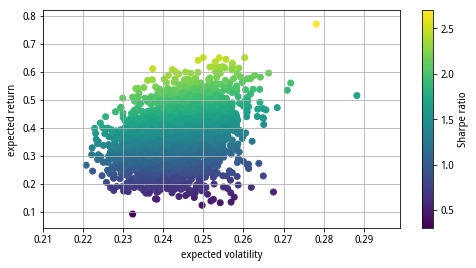

In [24]:
noa = len(test_return.columns)
rf=0.02
prets,pvols=[],[]
#2500次蒙特卡洛模拟
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(test_return_mean * weights))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(test_return_cov, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=(prets-rf) / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [25]:
import scipy.optimize as sco
prets = []
pvols = []
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(test_return_mean * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(test_return_cov, weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])
#目标函数：最小化夏普比率负值
def min_func_sharpe(weights):
    return -statistics(weights)[2]
#约束条件：所有权重和为1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# 我们还将参数值（权重）限制在0和l之间。 
bnds = tuple((0, 1) for x in range(noa))
#优化函数，记得initial guess
opts = sco.minimize(min_func_sharpe, noa * [1. / noa, ], method='SLSQP', bounds=bnds, constraints=cons)
opts

     fun: -4.0388082895807615
     jac: array([-0.05418616533279419, 1.046319305896759, 1.4669865369796753,
       1.4100927710533142, 1.4880161881446838, 1.0427232384681702,
       0.5150723457336426, -0.054558515548706055, 0.7333722710609436,
       -0.05474156141281128, 0.6603873372077942, 0.17082136869430542,
       2.6960699558258057, 1.4374317526817322, -0.05490797758102417])
 message: 'Optimization terminated successfully.'
    nfev: 173
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.1380916398158599, 1.8404331877941438e-16, 5.036661192281411e-16,
       0.0, 8.860642254637785e-16, 6.134759838848209e-16, 0.0,
       0.5279634633111909, 0.0, 0.20479689297315623, 0.0, 0.0,
       2.9004576518332215e-15, 1.8176649421719482e-16,
       0.12914800389979042])

In [26]:
# 投资组合权重
weight=opts['x'].round(3)
print(weight)
# 预期收益率, 预期波动率，最优夏普指数
print(statistics(opts['x'].round(3)))

[0.138 0.0 0.0 0.0 0.0 0.0 0.0 0.528 0.0 0.205 0.0 0.0 0.0 0.0 0.129]
[1.4997580534513006 0.3663848297753714 4.0388081961759505]


# 第五部分，简单回测

In [27]:
#进行一个简单回测
test_return["策略收益"]=test_return.apply(lambda x:np.dot(x,weight),axis=1)
test_return.head()

,603515.XSHG,600528.XSHG,601567.XSHG,603556.XSHG,600373.XSHG,600085.XSHG,603017.XSHG,601216.XSHG,603260.XSHG,601200.XSHG,600062.XSHG,600285.XSHG,600507.XSHG,603558.XSHG,603680.XSHG,策略收益
2020-02-04,0.018587,-0.012876,0.038567,0.006190,0.039443,-0.007774,-0.035011,-0.041825,-0.006372,-0.005747,0.011486,0.084351,0.037621,0.072727,-0.054444,-0.027720
2020-02-05,0.008921,0.006522,0.003979,-0.002051,0.009673,0.047365,0.009070,0.023810,0.028056,0.023121,0.063165,0.041965,0.036257,-0.017946,0.028202,0.022181
2020-02-06,0.016077,0.005400,0.029062,0.020548,0.100221,0.004760,0.013483,0.015504,-0.001559,0.053672,0.006008,0.006876,0.005643,0.010152,0.019429,0.023914
2020-02-07,0.035997,0.001074,-0.015404,0.048993,0.031480,-0.022673,0.018847,0.000000,-0.005857,0.100089,-0.043132,-0.020488,0.010101,0.018090,0.003363,0.025920
2020-02-10,-0.000764,0.019313,0.018253,-0.003199,-0.055844,-0.025623,0.014146,0.049618,0.027494,-0.027620,-0.018031,0.000000,0.026667,0.016782,0.016760,0.022593


/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "策略收益". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


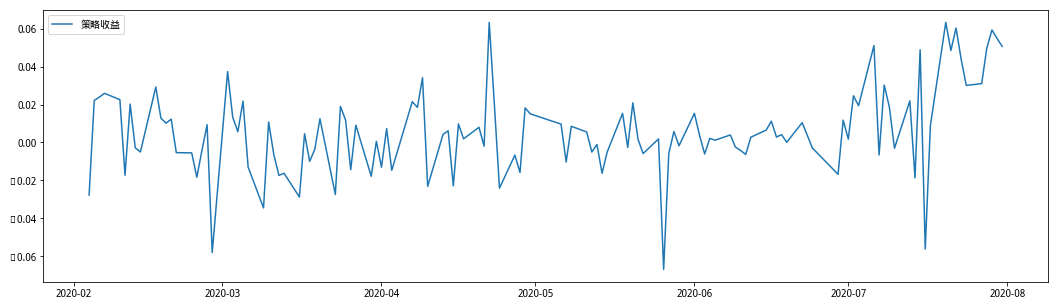

In [28]:
#打印个股以及组合策略的收益图。这里只打印组合收益图，想要全部去掉第二行if
for i in range(len(test_return.columns)):
    if i==len(test_return.columns)-1:
        plt.figure(figsize=[18,5])
        test_return.iloc[:,i].plot()
        plt.legend(loc=test_return.columns[i])

In [29]:
for name in test_return.columns:
    print(name)
    cum_return=test_return[name].mean()*252
    sharp_ratio=(cum_return-rf)/std(test_return[name])
    print("累计收益率： ",cum_return)
    print("夏普比率： ",sharp_ratio)

603515.XSHG
累计收益率：  0.49741953741607753
夏普比率：  22.26515593421112
600528.XSHG
累计收益率：  0.08162770260711427
夏普比率：  3.34213182262786
601567.XSHG
累计收益率：  0.07999312810663362
夏普比率：  2.33810338211428
603556.XSHG
累计收益率：  0.13235602707840788
夏普比率：  4.966679413379724
600373.XSHG
累计收益率：  0.050284894762722035
夏普比率：  1.1183993241107621
600085.XSHG
累计收益率：  -0.06710614785462019
夏普比率：  -6.036639509347918
603017.XSHG
累计收益率：  0.40945750145158966
夏普比率：  16.467943325264578
601216.XSHG
累计收益率：  2.3274439697940426
夏普比率：  60.67151460717875
603260.XSHG
累计收益率：  0.5517348052071157
夏普比率：  20.193763521946707
601200.XSHG
累计收益率：  0.5798585092503019
夏普比率：  23.954022954164767
600062.XSHG
累计收益率：  0.12293013470552516
夏普比率：  6.047067870380756
600285.XSHG
累计收益率：  0.6256056953850462
夏普比率：  22.767285158737685
600507.XSHG
累计收益率：  -0.5798375897750886
夏普比率：  -16.76581301009676
603558.XSHG
累计收益率：  0.09320233442173345
夏普比率：  2.3646876952325444
603680.XSHG
累计收益率：  0.6461453243435309
夏普比率：  25.56652509582161
策略收益
累计收益率：  1.4997580

累计收益率：  0.1991092274726649
夏普比率：  12.624994602860456


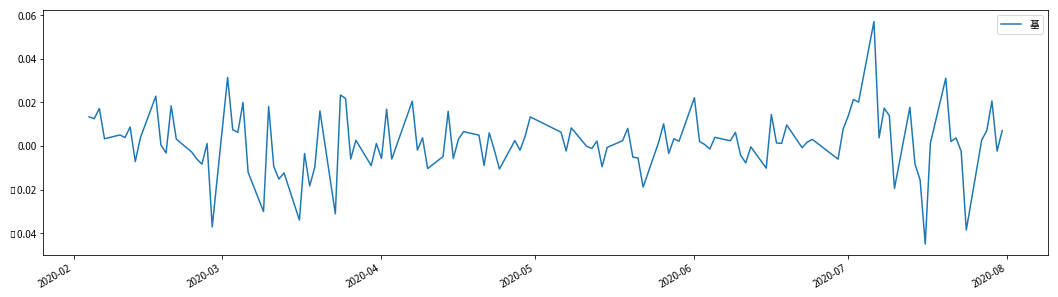

In [30]:
#查看基准收益
price_benchmark=get_price("000001.XSHG", start_date=startDate,end_date=endDate,fields=["close"],fq=None)
price_benchmark["return"]=(price_benchmark/price_benchmark.shift(1)-1).dropna()
cum_return=sum(price_benchmark["return"])

sharp_ratio=(cum_return-rf)/std(price_benchmark["return"])
print("累计收益率： ",cum_return)
print("夏普比率： ",sharp_ratio)
plt.figure(figsize=[18,5])
price_benchmark["return"].plot()
plt.legend("基准策略收益率")

In [31]:
stocks_list_result

['603515.XSHG',
 '600528.XSHG',
 '601567.XSHG',
 '603556.XSHG',
 '600373.XSHG',
 '600085.XSHG',
 '603017.XSHG',
 '601216.XSHG',
 '603260.XSHG',
 '601200.XSHG',
 '600062.XSHG',
 '600285.XSHG',
 '600507.XSHG',
 '603558.XSHG',
 '603680.XSHG']

In [32]:
weight

array([0.138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.528, 0.0, 0.205, 0.0, 0.0,
       0.0, 0.0, 0.129])